# Planner

![Swarm](../docs/planner.png)

## Define Tools

We will first define the tools we want to use. For this simple example, we will use a built-in search tool via Tavily. However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/how_to/custom_tools) on how to do that.

In [1]:
from langchain_tavily import TavilySearch
tavily_tool = TavilySearch()
tools = [tavily_tool]

In [2]:
tavily_tool.invoke("What is the capital of France?")

{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'List of capitals of France - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/List_of_capitals_of_France',
   'content': "List of capitals of France - Wikipedia Article [x] Tools  This is a chronological list of capitals of France. The capital of France has been Paris since its liberation in 1944.[1] Paris (987–1419), the residence of the Kings of France, although they were consecrated at Reims. Troyes (1419–1422), for a short time during the Hundred Years' War, the city was the seat of the royal government. Paris (1594–1682)[citation needed] Tours (10–13 June 1940), the city served as the temporary capital of France during World War II after the government fled Paris due to the German advance. Algiers (1943–1944), the city was made the seat of Free France, to be closer to the war in Europe. *   All articles needing additional references",
   'score': 0.

## Define our Execution Agent

Now we will create the execution agent we want to use to execute tasks. 
Note that for this example, we will be using the same execution agent for each task, but this doesn't HAVE to be the case.

In [3]:
from langchain_openai import AzureChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = AzureChatOpenAI(model="gpt-4.1-mini")
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [4]:
state = agent_executor.invoke({"messages": [("user", "Give me 5 must see museums in Paris")]})

for message in state["messages"]:
    message.pretty_print()

================================ Human Message =================================

Give me 5 must see museums in Paris
================================== Ai Message ==================================

Sure! Here are 5 must-see museums in Paris:

1. The Louvre Museum (Musée du Louvre) - The world's largest art museum, home to the Mona Lisa and countless other masterpieces.
2. Musée d'Orsay - Famous for its extensive collection of Impressionist and Post-Impressionist masterpieces.
3. Centre Pompidou - Known for its modern art collections and unique architecture.
4. Musée de l'Orangerie - Renowned for Monet's Water Lilies series.
5. Musée Rodin - Dedicated to the works of the sculptor Auguste Rodin, set in a beautiful garden.

Would you like more detailed information on any of these?


## Setup State
Intermediate memory for each step undertaken

In [5]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

## Planning Step

Let's now think about creating the planning step. This will use function calling to create a plan.

In [6]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [7]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)

In [8]:
planner.invoke(
    {
        "messages": [
            ("user", "i want 5 must see museums in paris , and what the entrance fee is in rupees")
        ]
    }
)

Plan(steps=['Identify the 5 must-see museums in Paris based on popularity and cultural significance.', 'For each museum, find the current entrance fee in euros from an official or reliable source.', 'Find the current exchange rate from euros to Indian rupees (INR).', "Convert each museum's entrance fee from euros to rupees using the exchange rate.", 'List the 5 museums along with their entrance fees in rupees as the final answer.'])

## Re-Plan Step

Now, let's create a step that re-does the plan based on the result of the previous step.

In [9]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | llm.with_structured_output(Act)

## Create the Graph

We can now create the graph!

In [10]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [11]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

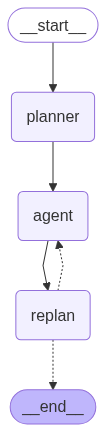

In [12]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
config = {"recursion_limit": 50}
inputs = {"input": "i want 5 must see museums in paris , and what the entrance fee is in rupees"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identify 5 must-see museums in Paris.', 'Find the entrance fee for each museum in euros.', 'Convert each entrance fee from euros to Indian rupees using the current exchange rate.', 'List the 5 museums along with their entrance fee in rupees.']}
{'past_steps': [('Identify 5 must-see museums in Paris.', "Here are 5 must-see museums in Paris:\n\n1. The Louvre Museum - The largest art museum in the world with an extensive collection spanning thousands of years.\n2. Musée d'Orsay - Known for its vast collection of Impressionist art.\n3. Palais de Tokyo - The largest contemporary art center in Europe.\n4. Picasso Museum - Dedicated to the works of Pablo Picasso.\n5. Musée Carnavalet - Focuses on the history of Paris.\n\nWould you like me to proceed to find the entrance fees for these museums?")]}
{'plan': ['Find the entrance fee for each museum in euros.', 'Convert each entrance fee from euros to Indian rupees using the current exchange rate.', 'List the 5 museums along with their